In [218]:
%matplotlib notebook
import matplotlib.pyplot as plt
import os
import six
import numpy as np
import json
import copy
from skbeam.core.fitting.xrf_model import (ModelSpectrum,update_parameter_dict,
                                           set_parameter_bound,
                                           register_strategy)
from skbeam.core.fitting.background import snip_method
from pyxrf.model.guessparam import define_range
from pyxrf.model.fit_spectrum import extract_strategy, combine_lines, single_pixel_fitting_controller

In [219]:
wd = '.'
data = np.loadtxt('LiLi-Example.txt')

<IPython.core.display.Javascript object>


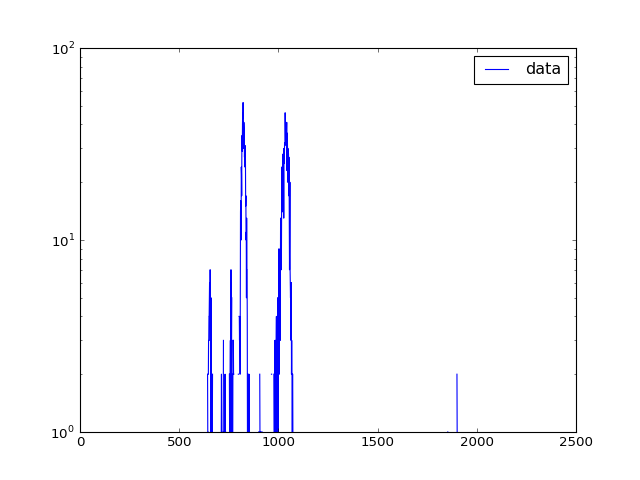

In [220]:
fig, ax = plt.subplots()
ax.semilogy(data, label='data')
plt.legend()

## Define parameters for fitting

In [255]:
# get parameter file
param_name = 'scan_7214_sum.json'
param_path = os.path.join(wd, param_name)
with open(param_path, 'r') as json_file:
    init_param = json.load(json_file)

param_dict = copy.deepcopy(init_param)
#param_dict = get_para()

In [256]:
param_dict['non_fitting_values']['element_list'] = 'Fe_K, Co_K, Ni_K, Cu_K'
elist = param_dict['non_fitting_values']['element_list'].split(',')
elist = [e.strip() for e in elist]
print('element to fit: {}'.format(elist))

element to fit: ['Fe_K', 'Co_K', 'Ni_K', 'Cu_K']


In [257]:
param_dict['coherent_sct_energy']['value'] = 10   # incident energy

In [258]:
# manually find calibration parameter
#8.04 = 822.3*a+b
#10 = 1041.1*a+b
a = (10-8.04)/(1041-822.3)
b = 8.04 - 823.3*a
print(a, b)

param_dict['e_offset']['value'] = b
param_dict['e_linear']['value'] = a
param_dict['e_quadratic']['value'] = 0

(0.00896204846822131, 0.661545496113396)


In [259]:
# define range
lowv = 1
highv = 11
param_dict['non_fitting_values']['energy_bound_low']['value'] = lowv
param_dict['non_fitting_values']['energy_bound_high']['value'] = highv
print('low and high boundary is {} and {} in KeV'.format(lowv, highv))

low and high boundary is 1 and 11 in KeV


In [260]:
# get x0 and y0 for fitting 
y_sum = np.array(data)
x0, y0 = define_range(y_sum, lowv, highv,
                      param_dict['e_offset']['value'],
                      param_dict['e_linear']['value'])

## Data fitting

In [261]:
bg = snip_method(y0,
                 param_dict['e_offset']['value'],
                 param_dict['e_linear']['value'],
                 param_dict['e_quadratic']['value'],
                 width=param_dict['non_fitting_values']['background_width'])

In [280]:
# basic function to perform fit
def fit_data(x, y, param_dict):
    elist = param_dict['non_fitting_values']['element_list'].split(',')
    elist = [e.strip() for e in elist]
    MS = ModelSpectrum(param_dict, elist)
    MS.assemble_models()
    #c_weight = 1
    #weights = 1/np.sqrt(c_weight + np.abs(y0))
    weights = None
    result = MS.model_fit(x0, y_for_fit,
                          weights=weights)
    return result

In [281]:
# remove background
y_for_fit = y0 - bg

In [282]:
# multiple fit
fit_strategy_list = ['fit_with_tail', 'linear']
#fit_strategy_list = ['linear']

for strat_name in fit_strategy_list:
    print(strat_name)
    strategy = extract_strategy(param_dict, strat_name)
    # register the strategy and extend the parameter list
    # to cover all given elements
    register_strategy(strat_name, strategy)
    set_parameter_bound(param_dict, strat_name)

    result = fit_data(x0, y_for_fit, param_dict)
    update_parameter_dict(param_dict, result)

fit_with_tail
linear


In [283]:
comp0 = result.eval_components(x=x0)
comp = combine_lines(comp0, elist, bg)

In [284]:
comp

{'Co_K': array([ 0.,  0.,  0., ...,  0.,  0.,  0.]),
 'Cu_K': array([  0.00000000e+000,   0.00000000e+000,   0.00000000e+000, ...,
          1.00071526e-138,   6.33595719e-140,   3.96426250e-141]),
 'Fe_K': array([ 0.,  0.,  0., ...,  0.,  0.,  0.]),
 'Ni_K': array([  0.00000000e+000,   0.00000000e+000,   0.00000000e+000, ...,
          1.01406734e-240,   2.66718983e-242,   6.93179689e-244]),
 'background': array([ 0.,  0.,  0., ...,  0.,  0.,  0.]),
 'compton': array([  1.71935896e-03,   1.71935896e-03,   1.71935897e-03, ...,
          1.85736354e-19,   9.34116018e-20,   4.67349694e-20]),
 'elastic': array([  0.00000000e+00,   0.00000000e+00,   0.00000000e+00, ...,
          6.89850719e-30,   1.89484546e-30,   5.14415335e-31])}

## View results

<IPython.core.display.Javascript object>


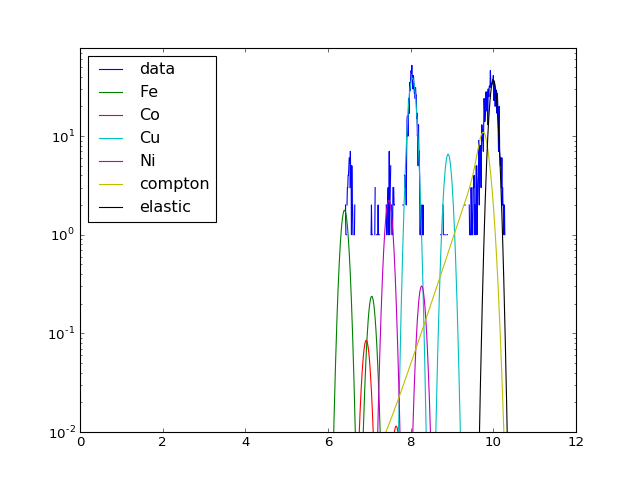

In [285]:
# add background back
fit_y = result.best_fit + bg

xv = result.best_values['e_offset'] + x0*result.best_values['e_linear']
fig, ax = plt.subplots()
ax.semilogy(xv, y0, '-', label='data')
#ax.semilogy(xv, fit_y, label='fit')
ax.semilogy(xv, comp['Fe_K'], label='Fe')
ax.semilogy(xv, comp['Co_K'], label='Co')
ax.semilogy(xv, comp['Cu_K'], label='Cu')
ax.semilogy(xv, comp['Ni_K'], label='Ni')
ax.semilogy(xv, comp['compton'], label='compton')
ax.semilogy(xv, comp['elastic'], label='elastic')
ax.set_ylim([1e-2, 1.5*np.max(y0)])
plt.legend(loc=2)

In [235]:
#print('value after fit is {}'.format(result.params))
# for k, v in dict(result.params):
#     if 'ka1' in v:
#         print(result.params[v])

In [251]:
print(result.fit_report())

[[Model]]
    (((((Model(compton) + Model(elastic, prefix='elastic_')) + (((Model(element_peak_xrf, prefix='Fe_ka1_') + Model(element_peak_xrf, prefix='Fe_ka2_')) + Model(element_peak_xrf, prefix='Fe_kb1_')) + Model(element_peak_xrf, prefix='Fe_kb3_'))) + (((Model(element_peak_xrf, prefix='Co_ka1_') + Model(element_peak_xrf, prefix='Co_ka2_')) + Model(element_peak_xrf, prefix='Co_kb1_')) + Model(element_peak_xrf, prefix='Co_kb3_'))) + (((Model(element_peak_xrf, prefix='Ni_ka1_') + Model(element_peak_xrf, prefix='Ni_ka2_')) + Model(element_peak_xrf, prefix='Ni_kb1_')) + Model(element_peak_xrf, prefix='Ni_kb3_'))) + (((Model(element_peak_xrf, prefix='Cu_ka1_') + Model(element_peak_xrf, prefix='Cu_ka2_')) + Model(element_peak_xrf, prefix='Cu_kb1_')) + Model(element_peak_xrf, prefix='Cu_kb3_')))
[[Fit Statistics]]
    # function evals   = 43
    # data points      = 1117
    # variables        = 6
    chi-square         = 735.721
    reduced chi-square = 0.662
[[Variables]]
    Cu_ka2_delt